In [3]:
!Cabocha -f1 data/neko.txt > work/neko.txt.cabocha

In [7]:
!wget https://nlp100.github.io/data/ai.ja.zip -P data/

--2020-07-09 11:07:04--  https://nlp100.github.io/data/ai.ja.zip
nlp100.github.io (nlp100.github.io) をDNSに問いあわせています... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
nlp100.github.io (nlp100.github.io)|185.199.108.153|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 17516 (17K) [application/zip]
`data/ai.ja.zip.1' に保存中

ai.ja.zip.1         100%[===================>]  17.11K  --.-KB/s 時間 0.1s       

2020-07-09 11:07:05 (118 KB/s) - `data/ai.ja.zip.1' へ保存完了 [17516/17516]



In [14]:
!unzip data/ai.ja.zip -d data/

Archive:  data/ai.ja.zip
  inflating: data/ai.ja.txt          
  inflating: data/readme.ai.ja.md    


In [ ]:
!pip install ginza

In [ ]:
!pip install spacy

In [21]:
!Cabocha -f1 data/ai.ja.txt > work/ai.ja.txt.cabocha

# 40. 係り受け解析結果の読み込み（形態素）

In [22]:
class Morph:
    def __init__(self, parse_result):
        morph = self._txt2morph(parse_result)
        self.surface = morph['surface']
        self.base = morph['base'] 
        self.pos = morph['pos'] 
        self.pos1 = morph['pos1']

    def _txt2morph(self, parse_result):
        splited_parse_result = parse_result.split('\t')
        splited_parse_result[1] = splited_parse_result[1].split(',')
        return {
            'surface':splited_parse_result[0],
            'base':splited_parse_result[1][6],
            'pos':splited_parse_result[1][0],
            'pos1':splited_parse_result[1][1]
        }
    
    def get_members_string(self):
        return f'surface : {self.surface}\tbase : {self.base}\tpos : {self.pos}\tpos1 : {self.pos1}'

In [23]:
def make_morph_sentence():
    with open('./work/ai.ja.txt.cabocha', mode = 'r') as f:
        sentence = list() 
        for line in f:
            line = line.rstrip()
            if line == 'EOS':
                if sentence: yield sentence
                sentence = list()
                continue
            if line[0] == '*' and line[1] == ' ': continue
            sentence.append(Morph(line))

In [24]:
from itertools import islice

In [25]:
gen_morph_sentence = make_morph_sentence()
for sentence in islice(gen_morph_sentence, 2):
    for morph in sentence:
        print(morph.get_members_string())
    print()

surface : 人工	base : 人工	pos : 名詞	pos1 : 一般
surface : 知能	base : 知能	pos : 名詞	pos1 : 一般

surface : 人工	base : 人工	pos : 名詞	pos1 : 一般
surface : 知能	base : 知能	pos : 名詞	pos1 : 一般
surface : （	base : （	pos : 記号	pos1 : 括弧開
surface : じん	base : じん	pos : 名詞	pos1 : 一般
surface : こうち	base : こうち	pos : 名詞	pos1 : 一般
surface : のう	base : のう	pos : 助詞	pos1 : 終助詞
surface : 、	base : 、	pos : 記号	pos1 : 読点
surface : 、	base : 、	pos : 記号	pos1 : 読点
surface : AI	base : *	pos : 名詞	pos1 : 一般
surface : 〈	base : 〈	pos : 記号	pos1 : 括弧開
surface : エーアイ	base : *	pos : 名詞	pos1 : 固有名詞
surface : 〉	base : 〉	pos : 記号	pos1 : 括弧閉
surface : ）	base : ）	pos : 記号	pos1 : 括弧閉
surface : と	base : と	pos : 助詞	pos1 : 格助詞
surface : は	base : は	pos : 助詞	pos1 : 係助詞
surface : 、	base : 、	pos : 記号	pos1 : 読点
surface : 「	base : 「	pos : 記号	pos1 : 括弧開
surface : 『	base : 『	pos : 記号	pos1 : 括弧開
surface : 計算	base : 計算	pos : 名詞	pos1 : サ変接続
surface : （	base : （	pos : 記号	pos1 : 括弧開
surface : ）	base : ）	pos : 記号	pos1 : 括弧閉
surface : 』	base : 』	pos : 記号	pos1 : 括弧閉
s

# 41. 係り受け解析結果の読み込み（文節・係り受け）

In [26]:
from operator import itemgetter
from functools import reduce

In [27]:
'''
Class Chunk
文節のクラス
---Member---
morphs: 形態素のリスト 
dst: 係り先文節インデックス番号
srcs: 係り元文節インデックス番号のリスト
'''
class Chunk(Morph):
    def __init__(self):
        self.morphs = list()
        self.dst = -1
        self.srcs = list()
    
    def append_morph(self, parse_result):
        self.morphs.append(Morph(parse_result))
        
    def append_srcs(self, src):
        self.srcs.append(src)
    
    def set_dst(self, dst):
        self.dst = dst
    
    def get_members_string(self):
        morphs = reduce(lambda a, b: a + '(' + b.get_members_string() + ')\n', self.morphs, '')
        return f'morphs : \n{morphs}dst : {self.dst}\tsrcs : {self.srcs}'

    def morphs2string(self):
        return reduce(lambda a, b: a + (b.surface if b.pos != '記号' else ''), self.morphs, '')
    
    def check_pos(self, pos):
        for morph in self.morphs:
            if morph.pos == pos: return True
        return False

In [28]:
def make_chunk_sentence():
    with open('./work/ai.ja.txt.cabocha', mode = 'r') as f:
        chunk_dict = dict()
        for line in f:
            line = line.rstrip()
            if line == 'EOS':
                sentence = [x[1] for x in sorted(chunk_dict.items(), key = itemgetter(0))]
                if sentence: yield sentence
                chunk_dict = dict()
                continue
            if line[0] == '*' and line[1] == ' ':
                splited_line = line.split()
                idx = int(splited_line[1])
                dst = int(splited_line[2][:-1])
                if not idx in chunk_dict: chunk_dict[idx] = Chunk()
                chunk_dict[idx].set_dst(dst)
                if dst != -1 and not dst in chunk_dict: chunk_dict[dst] = Chunk()
                if dst != -1: chunk_dict[dst].append_srcs(idx)
            else:
                chunk_dict[idx].append_morph(line)

In [29]:
gen_chunk_sentence = make_chunk_sentence()
for sentence in islice(gen_chunk_sentence, 2):
    for chunk in sentence:
        print(chunk.get_members_string())
    print()

morphs : 
(surface : 人工	base : 人工	pos : 名詞	pos1 : 一般)
(surface : 知能	base : 知能	pos : 名詞	pos1 : 一般)
dst : -1	srcs : []

morphs : 
(surface : 人工	base : 人工	pos : 名詞	pos1 : 一般)
(surface : 知能	base : 知能	pos : 名詞	pos1 : 一般)
dst : 17	srcs : []
morphs : 
(surface : （	base : （	pos : 記号	pos1 : 括弧開)
(surface : じん	base : じん	pos : 名詞	pos1 : 一般)
(surface : こうち	base : こうち	pos : 名詞	pos1 : 一般)
(surface : のう	base : のう	pos : 助詞	pos1 : 終助詞)
(surface : 、	base : 、	pos : 記号	pos1 : 読点)
(surface : 、	base : 、	pos : 記号	pos1 : 読点)
dst : 17	srcs : []
morphs : 
(surface : AI	base : *	pos : 名詞	pos1 : 一般)
dst : 3	srcs : []
morphs : 
(surface : 〈	base : 〈	pos : 記号	pos1 : 括弧開)
(surface : エーアイ	base : *	pos : 名詞	pos1 : 固有名詞)
(surface : 〉	base : 〉	pos : 記号	pos1 : 括弧閉)
(surface : ）	base : ）	pos : 記号	pos1 : 括弧閉)
(surface : と	base : と	pos : 助詞	pos1 : 格助詞)
(surface : は	base : は	pos : 助詞	pos1 : 係助詞)
(surface : 、	base : 、	pos : 記号	pos1 : 読点)
dst : 17	srcs : [2]
morphs : 
(surface : 「	base : 「	pos : 記号	pos1 : 括弧開)
(surface : 『	bas

# 42. 係り元と係り先の文節の表示

In [51]:
gen_sentence = make_chunk_sentence()
for sentence in islice(gen_sentence, 2):
    for chunk in sentence:
        if chunk.dst != -1: print(f'{chunk.morphs2string()}\t{sentence[chunk.dst].morphs2string()}')
    print()


人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語
語	研究分野とも
言語の	推論
理解や	推論
推論	問題解決などの
問題解決などの	知的行動を
知的行動を	代わって
人間に	代わって
代わって	行わせる
コンピューターに	行わせる
行わせる	技術または
技術または	研究分野とも
計算機	コンピュータによる
コンピュータによる	情報処理システムの
知的な	情報処理システムの
情報処理システムの	実現に関する
設計や	実現に関する
実現に関する	研究分野とも
研究分野とも	される



# 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [31]:
noun_to_verb = list()
for sentence in make_chunk_sentence():
    for chunk in sentence:
        if chunk.dst == -1: continue
        if chunk.check_pos('名詞') and sentence[chunk.dst].check_pos('動詞'):
            noun_to_verb.append((chunk.morphs2string(), sentence[chunk.dst].morphs2string()))

In [32]:
for idx in range(5):
    print(noun_to_verb[idx])

('道具を', '用いて')
('知能を', '研究する')
('一分野を', '指す')
('知的行動を', '代わって')
('人間に', '代わって')


# 44. 係り受け木の可視化

In [33]:
import pydot
from IPython.display import Image, display

In [34]:
graph = pydot.Dot(graph_type = 'digraph')
for sentence in islice(make_chunk_sentence(), 5, 6):
    for idx, chunk in enumerate(sentence):
        if chunk.dst == -1: continue
        id1 = idx
        id2 = chunk.dst
        label1 = chunk.morphs2string()
        label2 = sentence[id2].morphs2string()
        graph.add_node(pydot.Node(id1, label=label1))
        graph.add_node(pydot.Node(id2, label=label2))
        graph.add_edge(pydot.Edge(id1, id2))

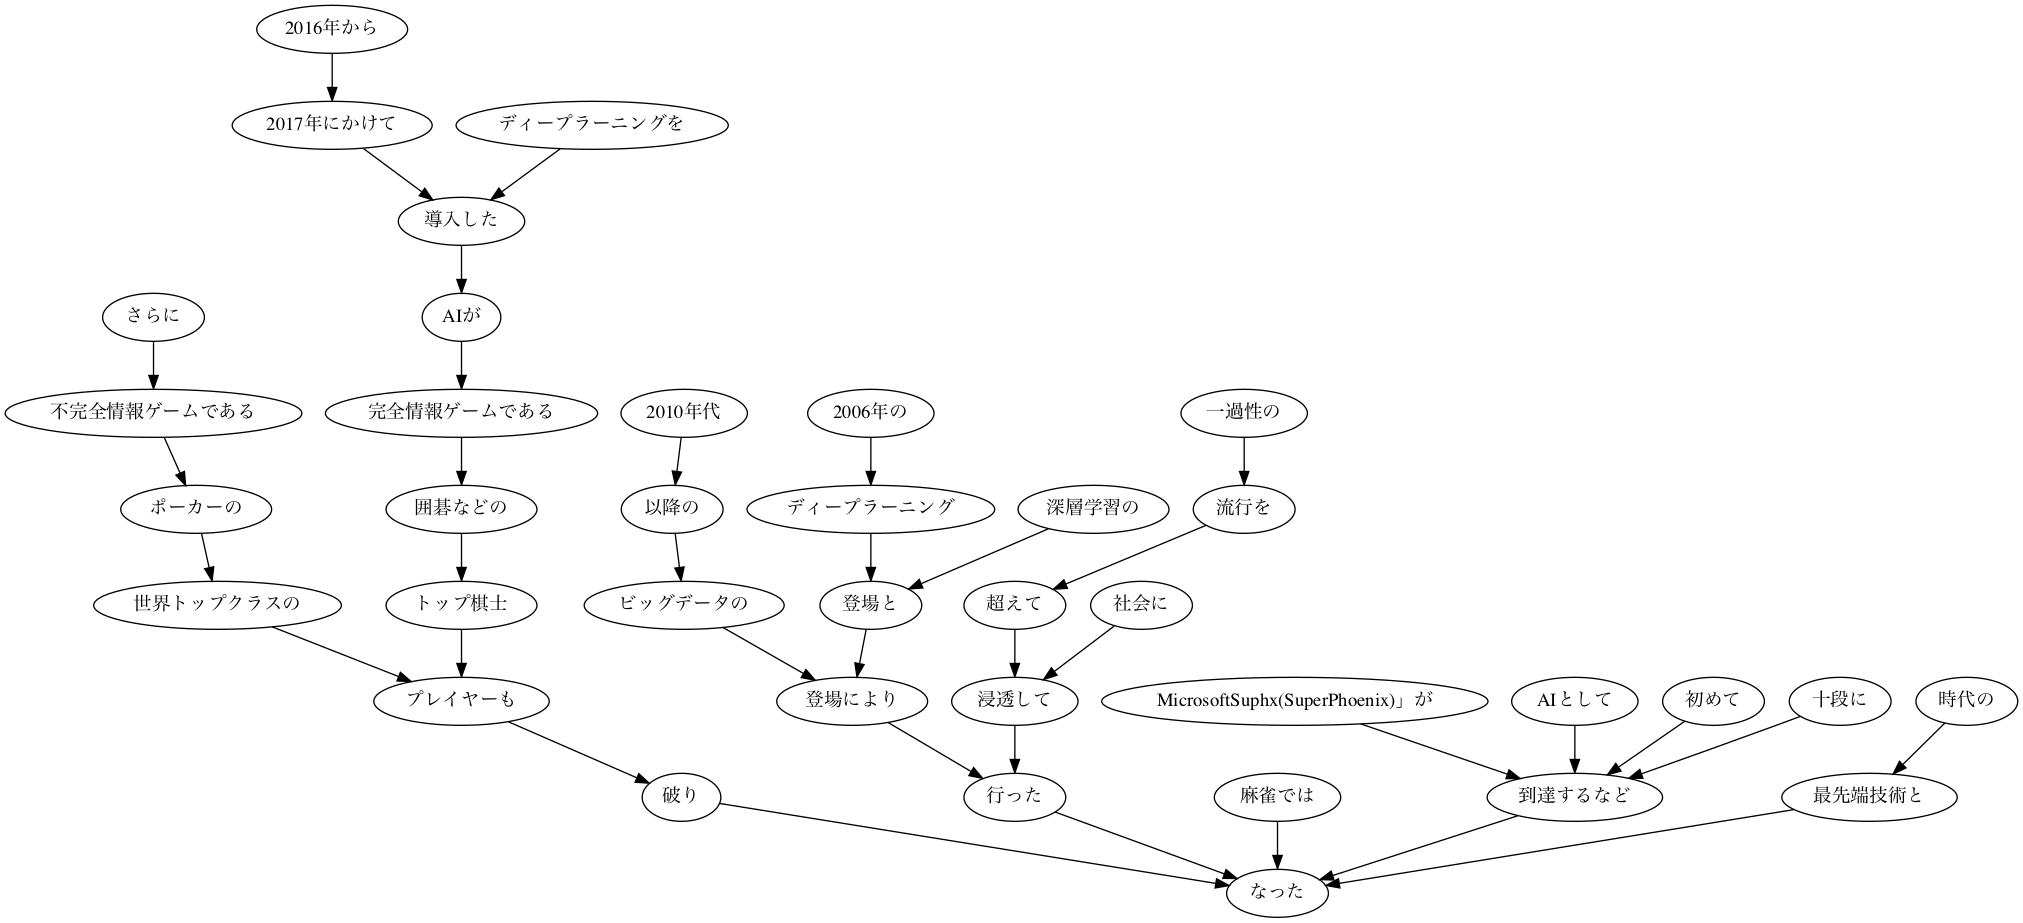

In [35]:
plt = Image(graph.create_png())
display(plt)

# 45. 動詞の格パターンの抽出

In [36]:
with open('./work/case_info.txt', mode = 'w') as out_file:
    for sentence in make_chunk_sentence():
        for chunk in sentence:
            verb = ''
            for morph in chunk.morphs:
                if morph.pos == '動詞':
                    verb = morph.base
                    break
            if verb:
                particle_list = list()
                for src in chunk.srcs:
                    src_chunk = sentence[src]
                    if src_chunk.morphs[-1].pos == '記号' and len(src_chunk.morphs) > 1: morph = src_chunk.morphs[-2]
                    else: morph = src_chunk.morphs[-1]
                    if morph.pos == '助詞':
                        particle_list.append(morph.base)
                if particle_list:
                    out_file.write(verb + '\t' + ' '.join(sorted(particle_list)) + '\n')

一文節内に複数の助詞がある場合どうすんnen(文節の最後に助詞が来ているもののみを抽出)

In [37]:
!cat ./work/case_info.txt | sort | uniq -c | sort -r | head -n 10 

     53 する	を
     19 する	と
     19 する	が
     16 する	に
     14 する	は を
     11 よる	に
     10 する	に を
      9 する	と は
      9 する	で を
      9 行う	を


In [38]:
!grep -E "^する|^見る|^与える" ./work/case_info.txt | sort | uniq -c | sort -r | head -n 10 

     53 する	を
     19 する	と
     19 する	が
     16 する	に
     14 する	は を
     10 する	に を
      9 する	と は
      9 する	で を
      7 する	が に
      6 する	と を


In [39]:
!awk '{if(match($1, "^する|^見る|^与える")){print $0}}' ./work/case_info.txt | sort | uniq -c | sort -r | head -n 10

     53 する	を
     19 する	と
     19 する	が
     16 する	に
     14 する	は を
     10 する	に を
      9 する	と は
      9 する	で を
      7 する	が に
      6 する	と を


# 46. 動詞の格フレーム情報の抽出

In [40]:
with open('./work/case_frame_info.txt', mode = 'w') as out_file:
    for sentence in make_chunk_sentence():
        for chunk in sentence:
            verb = ''
            for morph in chunk.morphs:
                if morph.pos == '動詞':
                    verb = morph.base
                    break
            if verb:
                particle_clause_list = list()
                for src in chunk.srcs:
                    src_chunk = sentence[src]
                    #最後の場所が助詞の場合のみ抽出(記号があった場合めんどくさ)
                    if src_chunk.morphs[-1].pos == '記号' and len(src_chunk.morphs) > 1: morph = src_chunk.morphs[-2]
                    else: morph = src_chunk.morphs[-1]
                    if morph.pos == '助詞':
                        particle_clause_list.append((morph.base, sentence[src].morphs2string()))
                if particle_clause_list:
                    sorted_particle_clause_list = sorted(particle_clause_list)
                    particle_list = [x[0] for x in sorted_particle_clause_list]
                    clause_list = [x[1] for x in sorted_particle_clause_list] 
                    out_file.write(verb + '\t' + ' '.join(particle_list) + '\t' + ' '.join(clause_list) + '\n')

助詞と同じ基準ってなんやねん(助詞でソート)

# 47. 機能動詞構文のマイニング

In [41]:
with open('./work/case_frame_util_info.txt', mode = 'w') as out_file:
    for sentence in make_chunk_sentence():
        for idx, chunk in enumerate(sentence):
            if len(chunk.morphs) == 2:
                morphs = chunk.morphs 
                if morphs[0].pos == '名詞' and morphs[0].pos1 == 'サ変接続' and morphs[1].surface == 'を' and morphs[1].pos == '助詞':
                    if chunk.dst != -1 and sentence[chunk.dst].check_pos('動詞'):
                        verb = ''
                        for morph in sentence[chunk.dst].morphs:
                            if morph.pos == '動詞':
                                verb = morph.base
                                break
                        particle_clause_list = list()
                        for src in sentence[chunk.dst].srcs:
                            if src == idx: continue
                            src_chunk = sentence[src]
                            if src_chunk.morphs[-1].pos == '記号' and len(src_chunk.morphs) > 1: morph = src_chunk.morphs[-2]
                            else: morph = src_chunk.morphs[-1]
                            if morph.pos == '助詞':
                                particle_clause_list.append((morph.base, sentence[src].morphs2string()))
                        if particle_clause_list:
                            sorted_particle_clause_list = sorted(particle_clause_list)
                            particle_list = [x[0] for x in sorted_particle_clause_list]
                            clause_list = [x[1] for x in sorted_particle_clause_list] 
                            out_file.write(chunk.morphs2string() + verb + '\t' + ' '.join(particle_list) + '\t' + ' '.join(clause_list) + '\n')

In [42]:
!cat ./work/case_frame_util_info.txt | cut -f 1 | sort | uniq -c | sort -r | head -n 10 

      3 注目を集める
      2 運転をする
      1 進化を見せる
      1 追及を受ける
      1 禁止を求める
      1 研究を進める
      1 研究を続ける
      1 反乱を起こす
      1 開発を行う
      1 議論を行う


In [43]:
!cat ./work/case_frame_util_info.txt | cut -f1,2 | sort | uniq -c | sort -r | head -n 10 

      1 注目を集める	から は
      1 進化を見せる	て において は
      1 反乱を起こす	て に対して
      1 追及を受ける	で と とともに は
      1 禁止を求める	が は
      1 研究を続ける	が て
      1 研究を進める	て
      1 注目を集める	に
      1 注目を集める	が
      1 議論を行う	まで


# 48. 名詞から根へのパスの抽出

In [44]:
def rec(chunk, sentence, noun_path_idx):
    noun_path_idx.append(chunk.dst)
    if chunk.dst == -1: return
    rec(sentence[chunk.dst], sentence, noun_path_idx)

    
def noun_path_idx2noun_path(noun_path_idx, sentence):
    return [sentence[idx].morphs2string() for idx in noun_path_idx if idx != -1]

In [45]:
noun_path_list = list()
for sentence in islice(make_chunk_sentence(), 10):
    for idx, chunk in enumerate(sentence):
        if chunk.check_pos('名詞'):
            noun_path_idx = [idx]
            rec(chunk, sentence, noun_path_idx)
            noun_path_list.append(noun_path_idx2noun_path(noun_path_idx, sentence))

In [46]:
for idx in range(20):
    noun_path = noun_path_list[idx]
    print(' -> '.join(noun_path))

人工知能
人工知能 -> 語 -> 研究分野とも -> される
じんこうちのう -> 語 -> 研究分野とも -> される
AI -> エーアイとは -> 語 -> 研究分野とも -> される
エーアイとは -> 語 -> 研究分野とも -> される
計算 -> という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
概念と -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
コンピュータ -> という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
知能を -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
研究する -> 計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
計算機科学 -> の -> 一分野を -> 指す -> 語 -> 研究分野とも -> される
一分野を -> 指す -> 語 -> 研究分野とも -> される
語 -> 研究分野とも -> される
言語の -> 推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
理解や -> 推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
知的行動を -> 代わって -> 行わせる -> 技術または -> 研究分野とも -> される
人間に -> 代わって -> 行わせる -> 技術または 

# 49. 名詞間の係り受けパスの抽出

In [47]:
def mask(chunk, mask_char):
    masked_string = ''
    for morph in chunk.morphs:
        if morph.pos == '名詞':
            masked_string += mask_char
        else:
            if morph.pos == '記号': continue
            masked_string += morph.surface
    return masked_string

In [48]:
noun_to_noun_path_list = list()
for sentence in make_chunk_sentence():
    for x_idx, x_chunk in enumerate(sentence):
        if not x_chunk.check_pos('名詞'): continue
        for y_idx, y_chunk in enumerate(sentence[x_idx + 1:]):
            y_idx += x_idx + 1
            if not y_chunk.check_pos('名詞'): continue
            x_noun_path_idx = [x_idx]
            rec(x_chunk, sentence, x_noun_path_idx)
            y_noun_path_idx = [y_idx]
            rec(y_chunk, sentence, y_noun_path_idx)
            while x_noun_path_idx and y_noun_path_idx and x_noun_path_idx[-1] == y_noun_path_idx[-1]:
                x_noun = x_noun_path_idx.pop(-1)
                y_noun = y_noun_path_idx.pop(-1)
            if y_noun_path_idx:
                out_str = ''
                x_noun_path = noun_path_idx2noun_path(x_noun_path_idx, sentence)
                x_noun_path[0] = mask(x_chunk, 'X')
                out_str += ' -> '.join(x_noun_path) + ' | '
                y_noun_path = noun_path_idx2noun_path(y_noun_path_idx, sentence)
                y_noun_path[0] = mask(y_chunk, 'Y')
                out_str += ' -> '.join(y_noun_path) + ' | '
                out_str += sentence[x_noun].morphs2string()
                noun_to_noun_path_list.append(out_str)
            else:
                out_str = ''
                x_noun_path = noun_path_idx2noun_path(x_noun_path_idx, sentence)
                x_noun_path[0] = mask(x_chunk, 'X')
                x_noun_path.append(mask(y_chunk, 'Y'))
                out_str += ' -> '.join(x_noun_path)
                noun_to_noun_path_list.append(out_str)

In [49]:
for idx in range(30):
    print(noun_to_noun_path_list[idx])

XX | YYのう | 語
XX | Y -> エーアイとは | 語
XX | Yとは | 語
XX | Y -> という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す | 語
XX | Yと -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す | 語
XX | Y -> という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す | 語
XX | Yを -> 用いて -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す | 語
XX | Yを -> 研究する -> 計算機科学 -> の -> 一分野を -> 指す | 語
XX | Yする -> 計算機科学 -> の -> 一分野を -> 指す | 語
XX | YYY -> の -> 一分野を -> 指す | 語
XX | YYを -> 指す | 語
XX -> Y
XX -> 語 | Yの -> 推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または | 研究分野とも
XX -> 語 | Yや -> 推論 -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または | 研究分野とも
XX -> 語 | Y -> 問題解決などの -> 知的行動を -> 代わって -> 行わせる -> 技術または | 研究分野とも
XX -> 語 | YYなどの -> 知的行動を -> 代わって -> 行わせる -> 技術または | 研究分野とも
XX -> 語 | YYを -> 代わって -> 行わせる -> 技術または | 研究分野とも
XX -> 語 | Yに -> 代わって -> 行わせる -> 技術または | 研究分野とも
XX -> 語 | Yに -> 行わせる -> 技術または | 研究分野とも
XX -> 語 | Yまたは | 研究分野とも
XX -> 語 | YY -> コンピュータによる -> 情報処理システムの -> 実現に関する | 研究分野とも
XX -> 語 | Yによる -> 情報処理システムの -> 実現に関する | 研究分野とも
XX -> 語 | Yな -> 情

逆方向に係らないからi < jでおけ   
名詞句が複数ある場合のマスクどうすんnen